In [ ]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
np.random.seed(45)
import pandas as pd
import math
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.wrappers.scikit_learn import KerasClassifier

import keras_tuner as kt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Reading input train and test data. 
# train data will be used for model building and evaluation. 
# Test data will be used to validate the model performance on unseen data.

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fashion MNIST/fashion-mnist_train.csv')
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fashion MNIST/fashion-mnist_test.csv")
x_test = test.loc[:, test.columns != "label"]
y_test = test['label']

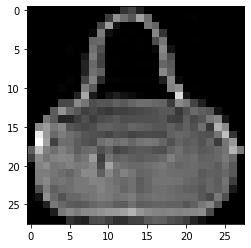

In [ ]:
# sample plot of a row from CSV to show the image. 

Image_index = 20
img = train.loc[Image_index, train.columns != "label"].values.reshape((28,28))
plt.imshow(img,cmap='gray')

In [ ]:
# Training data and label segregation.

y_data = train['label'].values
x_data = train.drop('label',axis=1)

In [ ]:
# dividing the training data into 80-20 ratio for train and validation. 

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2, random_state=169)

In [ ]:
 #this function plots the accury against the epochs.

def plot_accuracy_vs_epochs(history):
    epochs = len(history.history['val_accuracy'])+1
    fig = plt.figure(figsize=(6, 6))
    plt.plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.xlim([1,epochs])
    plt.grid(True)
    plt.title("Model Accuracy")
    plt.show()

In [ ]:
# this function plots the change in learning rate against the epchos.

def plot_learning_rate(loss_history):
# plot learning rate
  fig = plt.figure()
  plt.plot(range(1,epochs+1),loss_history.lrate,label='learning rate')
  plt.xlabel("epoch")
  plt.xlim([1,epochs+1])
  plt.ylabel("learning rate")
  plt.legend(loc=0)
  plt.grid(True)
  plt.title("Learning rate")
  plt.show()

In [ ]:
# function used for manaul validation.

def model_prediction(model, loc_num):
  model.predict(x_test).argmax(axis=1)
  img = x_test.iloc[loc_num].values.reshape((28,28))
  plt.imshow(img,cmap='gray')
  print("The predicted label is:" ,model.predict(x_test).argmax(axis=1)[loc_num])
  print("The actual label is: ", y_test[loc_num])

In [ ]:
# Function to create a basic model.

def nn_model_fancy(perceptrons_in_each_layer, 
                   hidden_activation, 
                   initializer, 
                   dropout_rate, 
                   optimiser_type, 
                   loss_fuction):
    model = keras.Sequential([
            # input layer
            keras.layers.Dense(perceptrons_in_each_layer, # hyperparameter 
                               activation= hidden_activation , # hyperparameter
                               input_shape=(784,), 
                               kernel_initializer=initializer # hyperparameter
                               ),
            # hidden layer 1                  
            keras.layers.Dense(perceptrons_in_each_layer, 
                               activation= hidden_activation,
                               kernel_initializer=initializer
                               ),
            # hidden layer 2
            keras.layers.Dense(perceptrons_in_each_layer, 
                               activation= hidden_activation,
                               kernel_initializer=initializer
                               ),

            keras.layers.Dropout(dropout_rate), # hyperparameter
            # Output layer
            keras.layers.Dense(10, activation=tf.nn.softmax)
        ]
    )
    model.summary()

    model.compile(optimizer = optimiser_type, # hyperparameter 
                  loss = loss_fuction,  # hyperparameter
                  metrics = ['accuracy'])

    return model

In [ ]:
# building basic model with Activation as relu

basic_model = nn_model_fancy (
perceptrons_in_each_layer = 128,
hidden_activation = "relu",
initializer = tf.keras.initializers.RandomNormal(stddev=0.01),
dropout_rate = 0 ,
optimiser_type = tf.keras.optimizers.SGD(learning_rate=0.001),
loss_fuction = "sparse_categorical_crossentropy",
)
#tf.keras.optimizers.SGD(learning_rate=0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


Epoch 1/20
375/375 [==============================] - 6s 4ms/step - loss: 0.9885 - accuracy: 0.6648 - val_loss: 0.6438 - val_accuracy: 0.7680
Epoch 2/20
375/375 [==============================] - 1s 4ms/step - loss: 0.5932 - accuracy: 0.7916 - val_loss: 0.5480 - val_accuracy: 0.8111
Epoch 3/20
375/375 [==============================] - 1s 4ms/step - loss: 0.5222 - accuracy: 0.8175 - val_loss: 0.4970 - val_accuracy: 0.8262
Epoch 4/20
375/375 [==============================] - 2s 4ms/step - loss: 0.4831 - accuracy: 0.8318 - val_loss: 0.4851 - val_accuracy: 0.8304
Epoch 5/20
375/375 [==============================] - 2s 5ms/step - loss: 0.4556 - accuracy: 0.8404 - val_loss: 0.4622 - val_accuracy: 0.8380
Epoch 6/20
375/375 [==============================] - 3s 7ms/step - loss: 0.4359 - accuracy: 0.8470 - val_loss: 0.4231 - val_accuracy: 0.8507
Epoch 7/20
375/375 [==============================] - 2s 5ms/step - loss: 0.4228 - accuracy: 0.8517 - val_loss: 0.4214 - val_accuracy: 0.8486
Epoch 

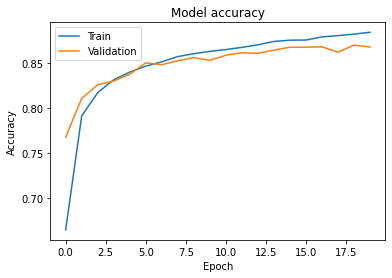

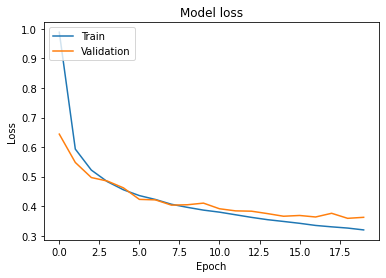

In [ ]:
batch_size = 128
epochs = 20
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
basic_model_history = basic_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
plot_history(basic_model_history)

In [ ]:
#Execution Time 37.75 Seconds FashionNet SGD with regularization